In [1]:
import keras
from keras.applications.vgg19 import VGG19
from keras.layers import Input
from keras.preprocessing import image
from keras.applications.vgg19 import preprocess_input, decode_predictions
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from tqdm import tqdm
from PIL import Image
from keras.utils import to_categorical
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pandas as pd
import os

C:\Users\user\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
C:\Users\user\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\user\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\user\Anaconda3\en

In [2]:
num_classes = 24
Epochs      = 15     #訓練次數
Batch_size  = 64     #批量大小
otsu_roi = True

In [3]:
path = "./original/"
fail = "./fail_img/"

if os.path.exists(fail) == False:
    os.makedirs(fail)

#只讀取 tif檔
def is_tif(x):
    return x.endswith('.tif')

folder = [x for x in sorted(os.listdir(path))]

In [4]:
#影像前處理，先刪除影像右側的黑條，接著使用 OTSU擷取手部影像
#也可使用 False 直接使用原圖做分類

def img_preprocess (raw_img,otsu_roi = otsu_roi ):
    if otsu_roi   == True :
        cv2_img   = cv2.cvtColor(raw_img, cv2.COLOR_BGR2GRAY)
        #remove black line at right side
        yy, xx    = cv2_img.shape
        cv2_img   = cv2_img[:yy, :xx-15]
        
        #影像膨脹
        kernel = np.ones((3,3), np.uint8)
        cv2_img   = cv2.dilate(cv2_img, kernel, iterations=1)
        
        #thershold with otsu
        t,thr_img = cv2.threshold(cv2_img,0,255,
                                  cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        #影像膨脹
        kernel = np.ones((3,3), np.uint8)
        thr_img   = cv2.dilate(thr_img, kernel, iterations=1)
        
        #using binary_img to remove background
        ROI       = cv2.bitwise_and(cv2_img, thr_img)
        #using cv2.findContours to find boundingBox
        contours, hierarchy = cv2.findContours(ROI, cv2.RETR_TREE, 
                                               cv2.CHAIN_APPROX_SIMPLE)
        x, y, w, h, = cv2.boundingRect(contours[0])
        crop_image  = np.array(ROI)[y:y+h, x:x+w]
        crop_image  = cv2.cvtColor(crop_image, cv2.COLOR_GRAY2BGR)
        return crop_image
    else:
        return raw_img

In [5]:
label_data  = pd.DataFrame()  #用於儲存test_Label
image_data  = pd.DataFrame() #用於儲存test_image
fail_img    = []

#讀取影像
for label  in tqdm(folder):
    img_path = path+label
    tif_file = [x for x in sorted(os.listdir(img_path))if is_tif(x)]
    
    for file in tif_file:
        file_path = img_path+"/"+file
        raw_img = cv2.imread(file_path)
        cv2_img = img_preprocess (raw_img, otsu_roi = otsu_roi )
        y,x ,z  = cv2_img.shape
        
        #如果擷取出來的影像長寬少於30，表示擷取失敗，並統計計算成功率
        if y+x > 30:
            if otsu_roi == True :
                cv2_img    = cv2.resize(cv2_img,(40,40), interpolation = cv2.INTER_NEAREST)
            image_data = image_data.append([[cv2_img]], ignore_index = True)  #將圖片儲存到相對應的dataframe
            label_data = label_data.append([int(label)],ignore_index = True)
        else:
            fail_path = fail+file 
            cv2.imwrite(fail_path+".jpg", cv2_img)
            fail_img.append(fail_path+".jpg")
            
input_shape=cv2_img.shape        
data_frame = pd.concat([image_data, label_data], axis=1, ignore_index = True, join_axes=[image_data.index])

100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:14<00:00,  1.65it/s]
C:\Users\user\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:28: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.


In [6]:
#失敗圖片以及成功率

pre_done = (1-(len(fail_img)/len(image_data)))*100
print("Fail Images:", len(fail_img))
print("Preprocess Rate : %s" % pre_done)

Fail Images: 0
Preprocess Rate : 100.0


In [7]:
image_raw = data_frame[0]
label_raw = data_frame[1]

In [8]:
def show_image(img):
    plt.imshow(img,cmap='gray')
    plt.axis('off')
    plt.title("hand")
    plt.show()

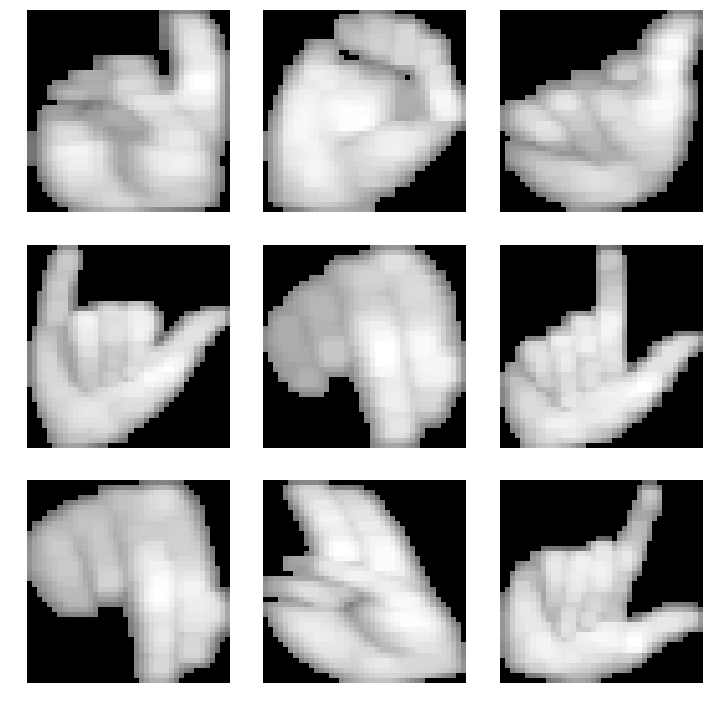

In [9]:
plt.figure(figsize=(10,10))
for  i in range(0,9):
    plt.subplot(3,3,i+1,)
    sad = np.random.randint(0, len(image_raw))
    plt.imshow(image_raw[sad], cmap='gray', interpolation='none')
    #plt.title("successful_img")
    plt.axis('off')
    plt.tight_layout()

In [10]:
if otsu_roi == True :
    if len(fail_img) > 0 :
        plt.figure(figsize=(10,10))
        for  i in range(0,9):
            plt.subplot(3,3,i+1,)
            sad = cv2.imread(fail_img[i])
            plt.imshow(sad, cmap='gray', interpolation='none')
            plt.title("Fail_img")
            plt.axis('off')
            plt.tight_layout()

In [11]:
#整理成可訓練的格式
image_raw = np.stack(image_raw)
label_raw = np.stack(label_raw)
label_raw.shape, image_raw.shape

((2400,), (2400, 40, 40, 3))

In [12]:
#打亂並 8:2 分為訓練以及測試

image_random, label_random = shuffle(image_raw,
                                    label_raw,
                                    random_state=1)

img_train, img_val, label_train, label_val = train_test_split(image_random,
                                                              label_random,
                                                              test_size=0.2,
                                                              random_state=0)
len(img_train),len(label_train),len(img_val),len(label_val)

(1920, 1920, 480, 480)

In [13]:
# One-Hot Encoding
label_train_onehot = np_utils.to_categorical(label_train)
label_val_onehot   = np_utils.to_categorical(label_val)

In [14]:
img_train.shape

(1920, 40, 40, 3)

In [15]:
def vgg19_model(input_shape):
    vgg19 = VGG19(include_top=False, weights='imagenet',input_shape=input_shape)
    for layer in vgg19.layers:
        layer.trainable = False
    last = vgg19.output
    x = Flatten()(last)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=vgg19.input, outputs=x)
    return model

In [16]:
model_vgg19 = vgg19_model(input_shape)
model_vgg19.compile(loss='categorical_crossentropy',optimizer = 'adam', metrics = ['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [17]:
train_history=model_vgg19.fit(x = img_train,
                              y = label_train_onehot, validation_split=0.1,
                              epochs=Epochs, batch_size=Batch_size,verbose=2)  

Instructions for updating:
Use tf.cast instead.
Train on 1728 samples, validate on 192 samples
Epoch 1/15
 - 4s - loss: 8.0090 - acc: 0.2980 - val_loss: 3.6641 - val_acc: 0.6771
Epoch 2/15
 - 1s - loss: 2.7739 - acc: 0.6863 - val_loss: 1.4415 - val_acc: 0.8594
Epoch 3/15
 - 1s - loss: 1.3980 - acc: 0.8275 - val_loss: 0.6327 - val_acc: 0.9219
Epoch 4/15
 - 2s - loss: 0.8975 - acc: 0.9016 - val_loss: 0.4521 - val_acc: 0.9427
Epoch 5/15
 - 2s - loss: 0.4032 - acc: 0.9196 - val_loss: 0.0759 - val_acc: 0.9688
Epoch 6/15
 - 2s - loss: 0.1244 - acc: 0.9624 - val_loss: 0.0414 - val_acc: 0.9792
Epoch 7/15
 - 2s - loss: 0.1132 - acc: 0.9635 - val_loss: 0.0335 - val_acc: 0.9844
Epoch 8/15
 - 2s - loss: 0.0775 - acc: 0.9740 - val_loss: 0.0254 - val_acc: 0.9948
Epoch 9/15
 - 2s - loss: 0.0668 - acc: 0.9792 - val_loss: 0.0196 - val_acc: 0.9948
Epoch 10/15
 - 2s - loss: 0.0566 - acc: 0.9809 - val_loss: 0.0123 - val_acc: 0.9948
Epoch 11/15
 - 2s - loss: 0.0544 - acc: 0.9821 - val_loss: 0.0123 - val_ac

In [18]:
scores = model_vgg19.evaluate(img_val , label_val_onehot)
scores[1]

480/480 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 1ms/step


1.0

In [19]:
import matplotlib.pyplot as plt  
def show_train_history(train_acc,test_acc):
    plt.plot(train_history.history[train_acc])
    plt.plot(train_history.history[test_acc])
    plt.title('TRAIN ACCURACY')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show() 

In [20]:
def show_train_loss_history(train_acc,test_acc):
    plt.plot(train_history.history[train_acc])
    plt.plot(train_history.history[test_acc])
    plt.title('TRAIN LOSS')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()  

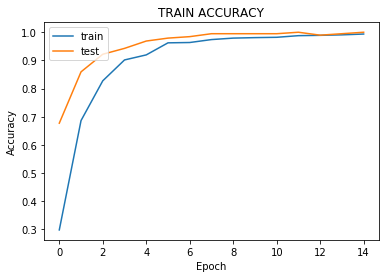

In [21]:
show_train_history('acc','val_acc')

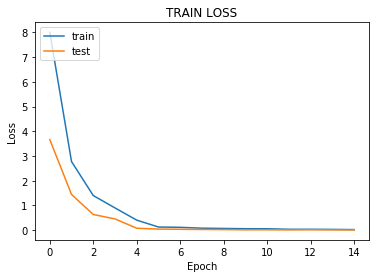

In [22]:
show_train_loss_history('loss','val_loss')

In [23]:
predicted_classes = model_vgg19.predict(img_val)

In [24]:
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)

In [25]:
predicted_classes.shape, label_val.shape

((480,), (480,))

Found 478 correct labels


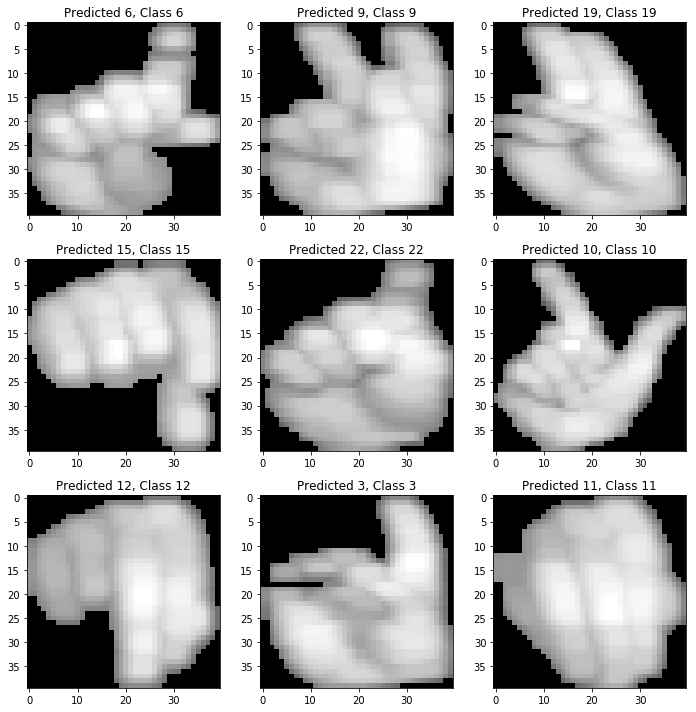

In [26]:
correct = np.where(predicted_classes==label_val)[0]
print ("Found %d correct labels" % len(correct))
plt.figure(figsize=(10,10))
for i, correct in enumerate(correct[:9]):
    plt.subplot(3,3,i+1,)
    plt.imshow(img_val[correct].reshape(input_shape), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct], label_val[correct]))
    plt.tight_layout()

Found 2 incorrect labels


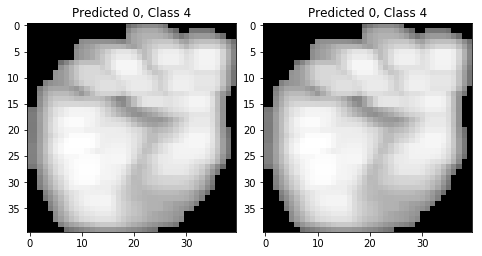

In [27]:
incorrect = np.where(predicted_classes!=label_val)[0]
print ("Found %d incorrect labels" % len(incorrect))
plt.figure(figsize=(10,10))
for i, incorrect in enumerate(incorrect[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(img_val[incorrect].reshape(input_shape), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], label_val[incorrect]))
    plt.tight_layout()